In [1]:
%matplotlib inline

In [2]:
import Signal
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import freqz
from scipy.signal import butter, lfilter
import scipy.signal as signal

## Generate Signal

In [3]:
def graph_signals(time_axis, array, signalNum=0, timestart = 0.06, dur=0.0003, sr=1000000):
    timeIdx = int(timestart*sr)
    durIdx = int(dur*sr)
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(time_axis[timeIdx:timeIdx + durIdx], array[signalNum][timeIdx:timeIdx+durIdx],'b-')
    plt.xlabel('Time (ms)')
    plt.ylabel('Charge (arbitrary)')
    plt.show()
    signals = []
    for signal in array:
        signals.append((time_axis[timeIdx:timeIdx + durIdx], signal[timeIdx:timeIdx+durIdx]))
    return signals

In [4]:
random.seed(1)
d = .1 #m
angle = 1.8 #rad
coords = [[0.005, 0.005], [0.005, -0.005], [-0.005, -0.005], [-0.005, 0.005]]
freq = 45 #kHz
sos = 1.5 #m/ms (MAY NEED TO BE CALIBRATED)
sr = 1000 #kHz
read = 2000 #ms
noise = 0.5 #standard deviation
time_on = 100 #ms --ping duration
ping_period = 2000 #ms
ping_start = 0

#create an array containing the simulated readings arrays of each sensor
signals = []
for i in range(len(coords)):
    signals.append(Signal.Signal(d, angle, coords[i], freq, sos, sr, read, noise, time_on, ping_period, ping_start).signals)
times = np.arange(0, read/1000, 1/(sr*1000))[:-1]

0.064302598751061
0.0707139770109018
0.06927127201945538
0.06271257281147843


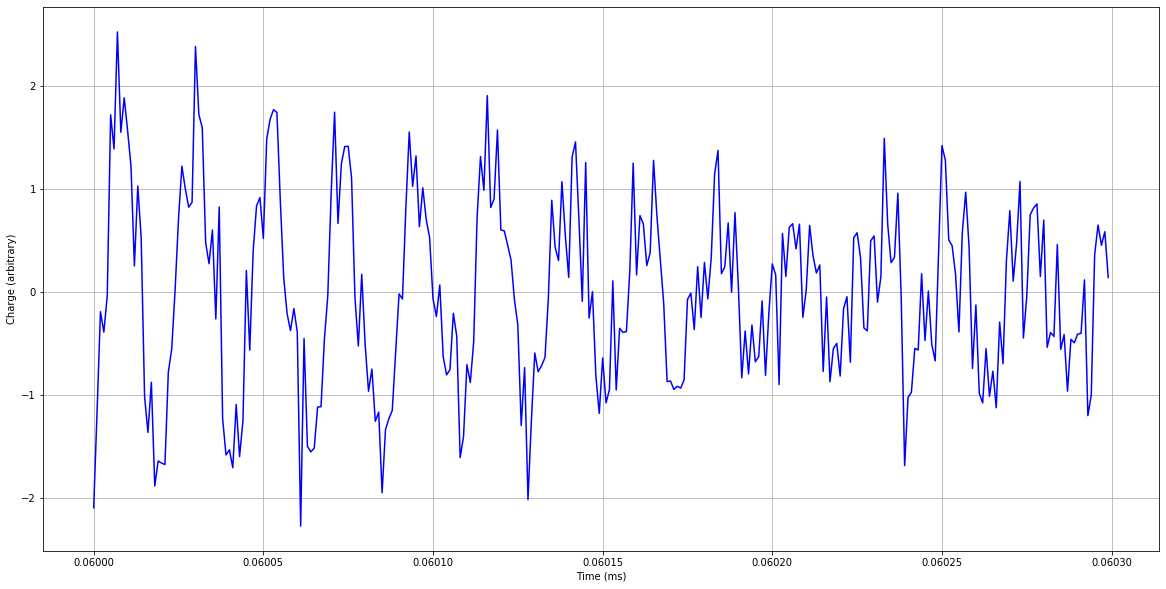

In [5]:
short_signals = graph_signals(times, signals, timestart=.06)

## Signal Processing

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [7]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
def bandpassFilter(signals):
    filtered_signals = []
    for signal in signals:
        diff = freq*.1
        lowcut = (freq-diff)*1000
        highcut = (freq+diff)*1000
        t = signal[0]
        y = butter_bandpass_filter(signal[1], lowcut, highcut, sr*1000, order=2)
        filtered_signals.append((t,y))
    return filtered_signals

In [9]:
filtered_signals = bandpassFilter(short_signals)

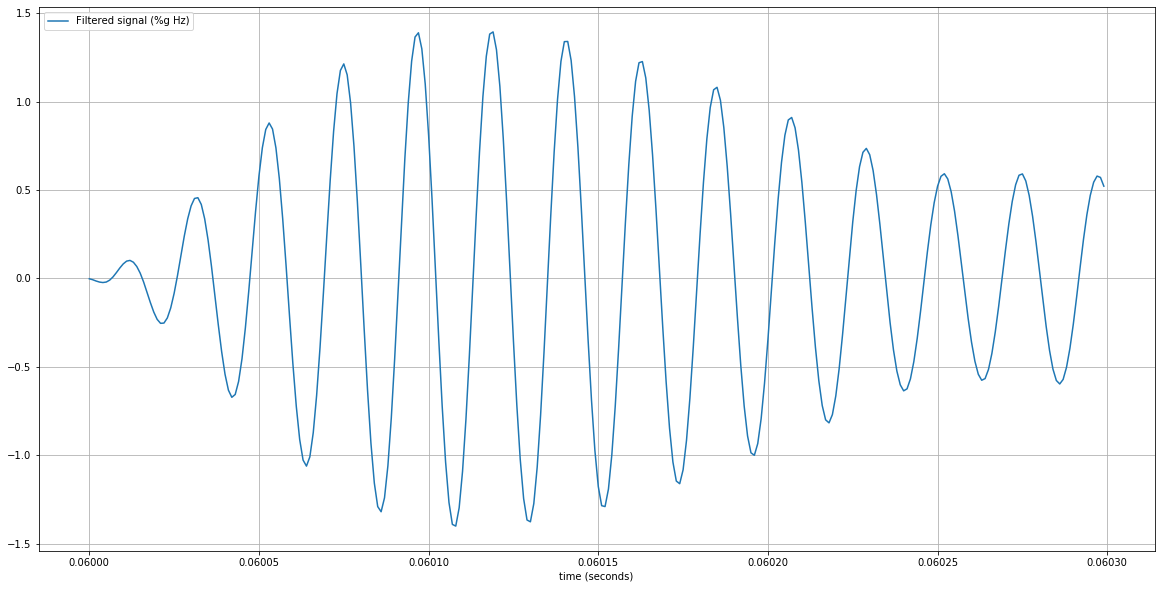

In [10]:
plt.figure(figsize = (20,10))
plt.plot(filtered_signals[0][0], filtered_signals[0][1], label='Filtered signal (%g Hz)')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## STFT

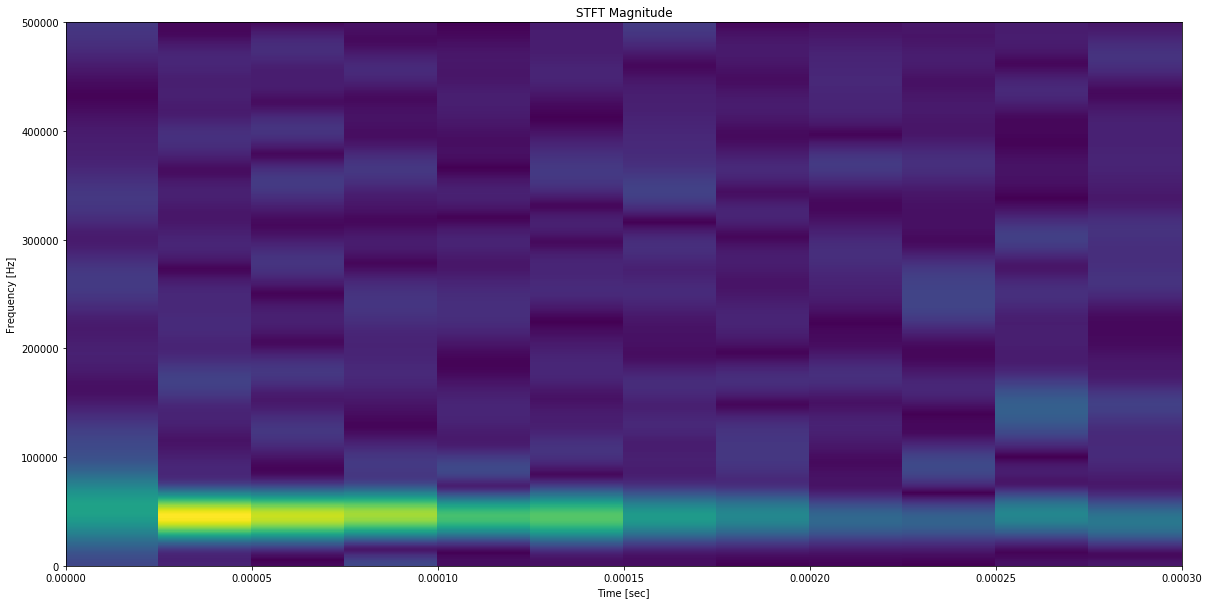

[     0.   1000.   2000.   3000.   4000.   5000.   6000.   7000.   8000.
   9000.  10000.  11000.  12000.  13000.  14000.  15000.  16000.  17000.
  18000.  19000.  20000.  21000.  22000.  23000.  24000.  25000.  26000.
  27000.  28000.  29000.  30000.  31000.  32000.  33000.  34000.  35000.
  36000.  37000.  38000.  39000.  40000.  41000.  42000.  43000.  44000.
  45000.  46000.  47000.  48000.  49000.  50000.  51000.  52000.  53000.
  54000.  55000.  56000.  57000.  58000.  59000.  60000.  61000.  62000.
  63000.  64000.  65000.  66000.  67000.  68000.  69000.  70000.  71000.
  72000.  73000.  74000.  75000.  76000.  77000.  78000.  79000.  80000.
  81000.  82000.  83000.  84000.  85000.  86000.  87000.  88000.  89000.
  90000.  91000.  92000.  93000.  94000.  95000.  96000.  97000.  98000.
  99000. 100000. 101000. 102000. 103000. 104000. 105000. 106000. 107000.
 108000. 109000. 110000. 111000. 112000. 113000. 114000. 115000. 116000.
 117000. 118000. 119000. 120000. 121000. 122000. 12

In [24]:
f, t, Zxx = signal.stft(short_signals[0][1], fs=sr*1000, nperseg=50, nfft=1000, boundary='zeros')
plt.figure(figsize=(20,10))
f = np.array(f)
idx = np.where(f == freq*1000)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(f, idx[0],freq*1000)

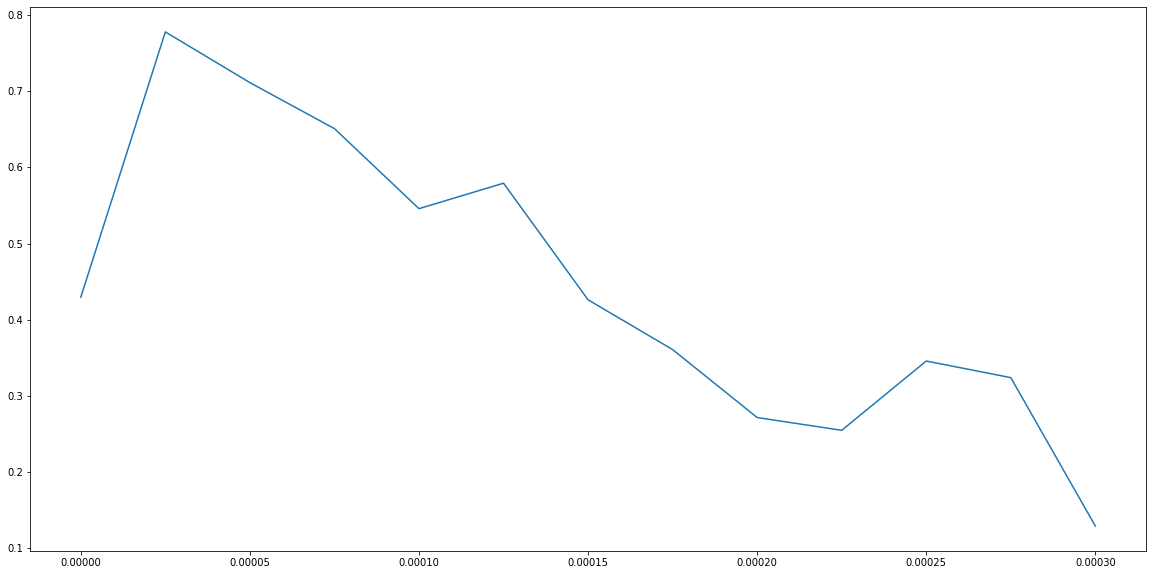

In [12]:
plt.figure(figsize=(20,10))
plt.plot(t, np.abs(Zxx[idx][0]))
plt.show()